<a href="https://colab.research.google.com/github/rdzotz/Forecaster/blob/master/ExampleColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Forecast NN Group 
The following code structures the task of forecasting through the use of Recurrent Neural Networks (RNN) and specifically LSTM's. For completeness and in the interest of object-oriented code I have placed the majority of the functions into a class forecasterNN. This class will be accessed through the following notebook. 


In [1]:
"""
Created on Sun Apr  5 23:16:36 2020

@author: rwilson
"""

'\nCreated on Sun Apr  5 23:16:36 2020\n\n@author: rwilson\n'

### The forecaster class

## Raw Data Analysis

Before selecting a reasonable forecaster to use, it makes sense to analyse the structure of the raw data. I will start by importing both tests and performing some basic signal analysis.

In [3]:
! git clone https://github.com/rdzotz/myDatasets.git

Cloning into 'myDatasets'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 43 (delta 2), reused 12 (delta 2), pack-reused 31
Unpacking objects: 100% (43/43), done.


In [4]:
! git clone https://github.com/rdzotz/Forecaster.git

Cloning into 'Forecaster'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 17 (delta 5), reused 10 (delta 2), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [0]:
from Forecaster.Forecaster import forecasterNN

In [13]:
folder_test1 = 'myDatasets/test1/'
folder_test3 = 'myDatasets/test3/'
# folder_test1 = 'Tests/test1'
# folder_test3 = 'Tests/test3'


# Note here I am importing all the available data into a single vector
# (see details of dataGet)
data_T1, _ = forecasterNN.dataGet(folder_test1, split=None)
data_T3, _ = forecasterNN.dataGet(folder_test3, split=None)
print('test1 data dims: {}'.format(data_T1.shape))
print('test3 data dims: {}'.format(data_T1.shape))

test1 data dims: (2000000, 1)
test3 data dims: (2000000, 1)


Let's analyse the time and frequency domain of the entire dataset

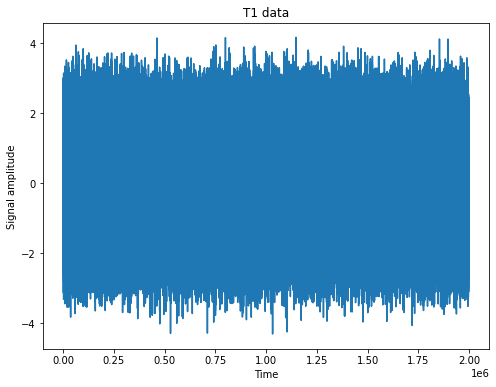

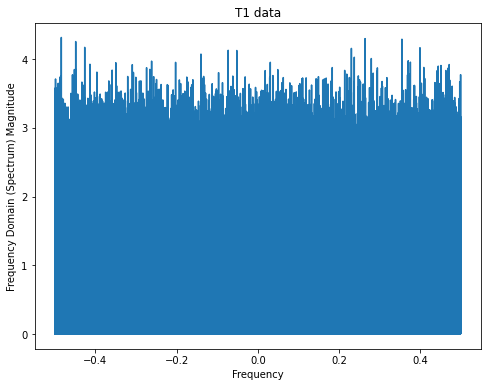

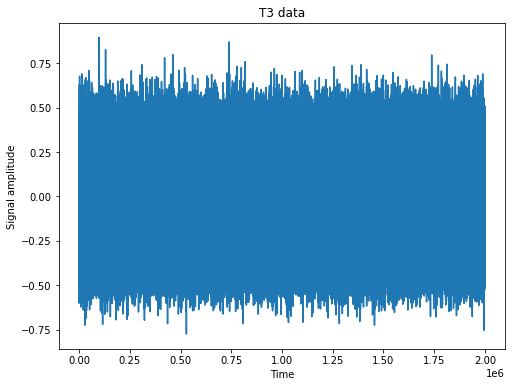

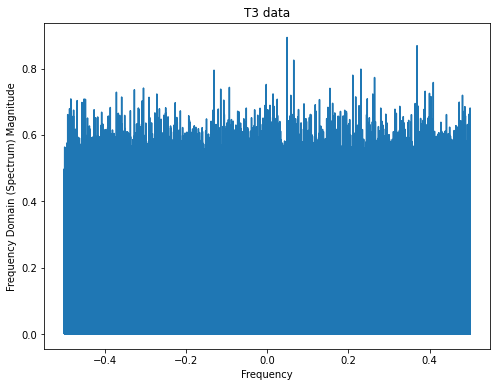

In [0]:
forecasterNN.dataFFT(data_T1, title='T1 data')

forecasterNN.dataFFT(data_T3, title='T3 data')

From the analysis of both the time and frequency domain, the datasets appear to be white noise. That is to say, they have a flat and broad frequency spectrum. This makes the application of forecasters difficult, as by definition a truly random signature cannot be forecast in a meaningful sense. Let's have a look at a few statistical features of the time series. 

In [0]:
print('The mean of the entire T1 dataset is %g ' %data_T1.mean())
print('The varience of the entire T1 dataset is %g ' %data_T1.std()**2)

print('The mean of the entire T3 dataset is %g ' %data_T3.mean())
print('The varience of the entire T3 dataset is %g ' %data_T3.std()**2)

The mean of the entire T1 dataset is 0.000605421 
The varience of the entire T1 dataset is 0.821905 
The mean of the entire T3 dataset is -3.00915e-05 
The varience of the entire T3 dataset is 0.0264563 


The test1 dataset shows both a larger mean and varience when compared to the test3 dataset which has a negative mean. If we perform the analysis for each month of the original data format (assuming each column represents a full month of data), some underlaying trends are evident.

In [0]:
dataM_T1, _ = forecasterNN.dataGet(folder_test1, split=None, unstack=False)
dataM_T3, _ = forecasterNN.dataGet(folder_test3, split=None, unstack=False)
print('test1 data dims: {}'.format(dataM_T1.shape))
print('test3 data dims: {}'.format(dataM_T3.shape))

test1 data dims: (80000, 25)
test3 data dims: (80000, 25)


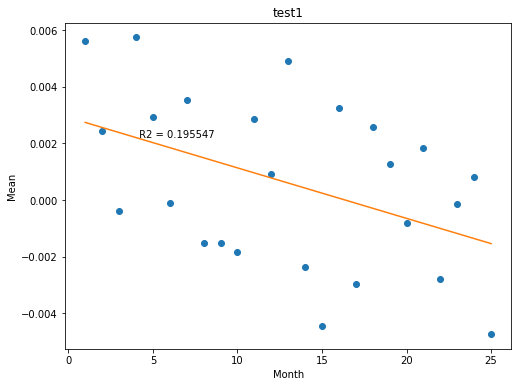

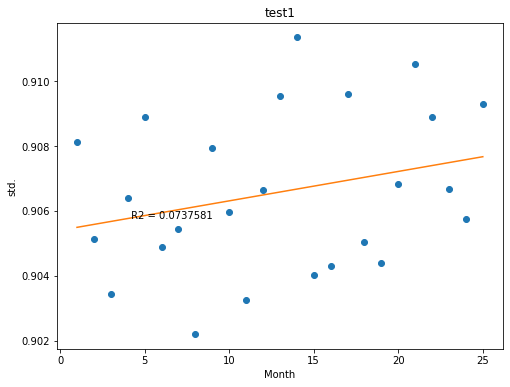

In [0]:
stats_T1 = forecasterNN.dataStats(dataM_T1, title='test1')

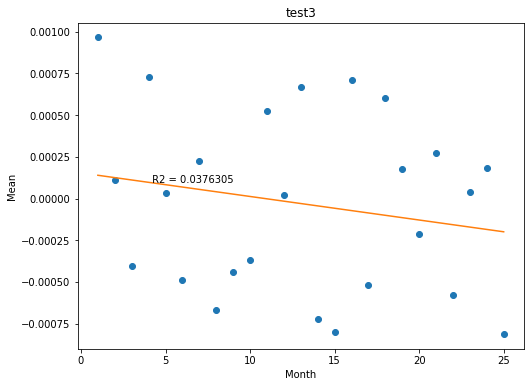

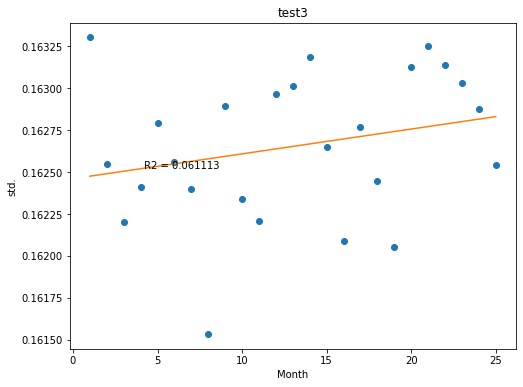

In [0]:
stats_T3 = forecasterNN.dataStats(dataM_T3, title='test3')

In both datasets the mean shows a negative slope and the varience shows a positive slope. The R2 fit quality is low for both datasets though the slight transient behavoir is less evident in Test3. In conclusion both datasets are slightly non-stationary.

# Baseline forecaster
For the purpose of the following analysis I will consider a prediction based on the extrapolation of our line-of-best fit as the baseline from which we want to improve our prediction. Excluding the final month from our line of best fit, and then extrapolating will proivde a very basic estimation of both the mean and varience. We can later use this simple forecaster, to determine if our more advanced method is really providing additional predictive power.

In [0]:
print('test1 data dims: {}'.format(dataM_T1[:,:-1].shape))
print('test3 data dims: {}'.format(dataM_T3[:,:-1].shape))

stats_T124_M = forecasterNN.dataStats(dataM_T1[:,:-1], plot=False)
stats_T324_M = forecasterNN.dataStats(dataM_T3[:,:-1], plot=False)

test1 data dims: (80000, 24)
test3 data dims: (80000, 24)


Firstly for the mean, forecasting the trend one month

The squared error for test1 mean is 1.41e-05
The squared error for test1 std. is 3.62e-06
The squared error for test3 mean is 5.2e-07
The squared error for test3 std. is 1.17e-07


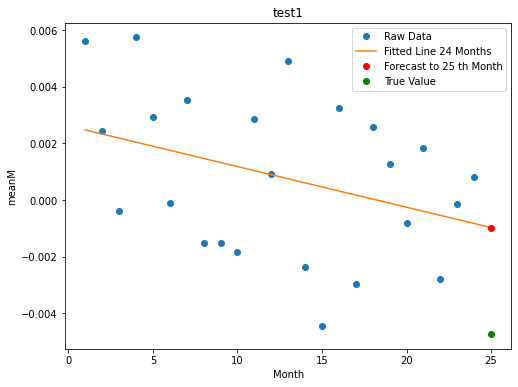

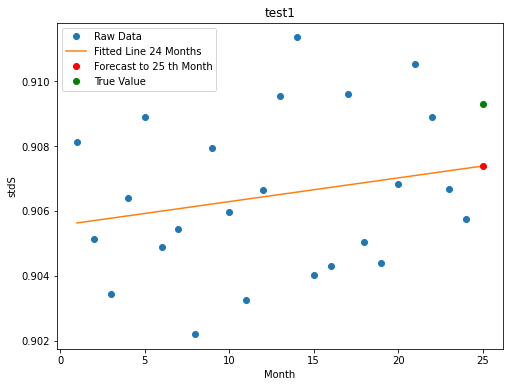

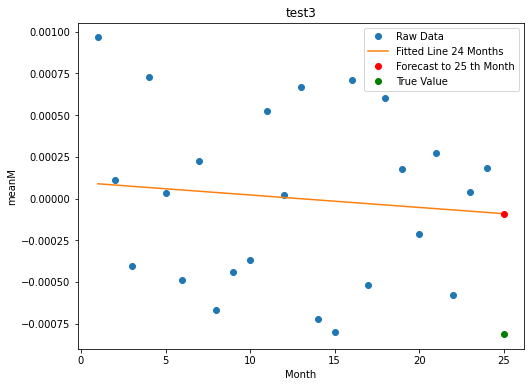

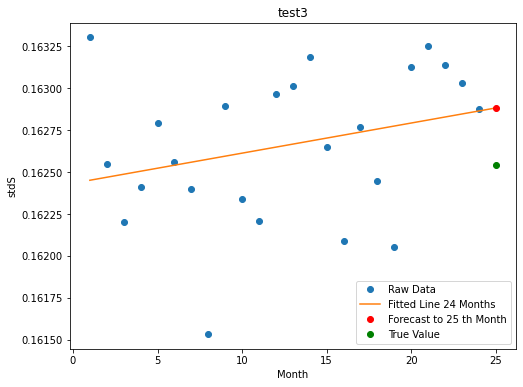

In [0]:
# Standadise the data
baseErrorTest1M, baseErrorTest1S = forecasterNN.baselinePlot(dataM_T1, 1, title = 'test1', standadize=False)
baseErrorTest3M, baseErrorTest3S = forecasterNN.baselinePlot(dataM_T3, 1, title = 'test3', standadize=False)

Secondly for the varience, forecasting the trend one month

# More Detailed Data Analysis
Now to investigate further if there exists drift within each "month" of data. Here we investigate for a rolling window of 80000 sample points which corresponds to one month of data, and trends in both mean and standard deviation. The 25th month data is plotted in red as an indication of what we want to forecast.

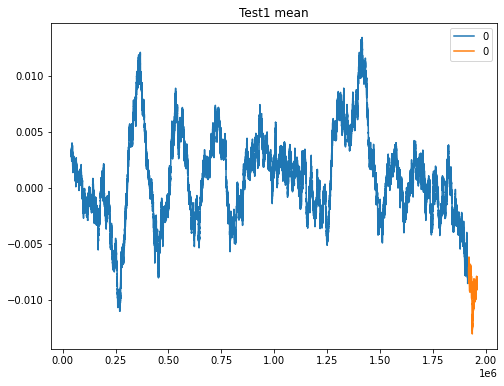

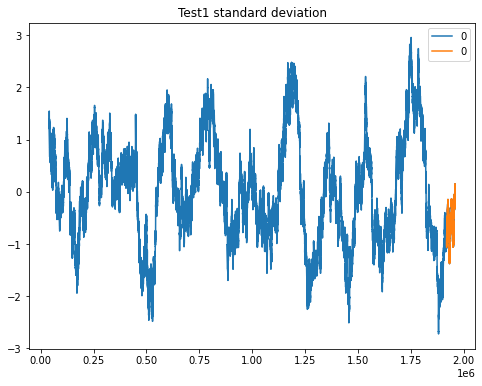

In [0]:
df_T1 = pd.DataFrame(data_T1)
windowW=80000
df_T1_M_roll = df_T1.rolling(window=windowW, win_type=None, center=True).mean()
ax = df_T1_M_roll.iloc[0:df_T1_M_roll.shape[0]-windowW].plot(title='Test1 mean')
df_T1_M_roll.iloc[df_T1_M_roll.shape[0]-windowW:].plot(ax=ax)



df_T1_V_roll = df_T1.rolling(window=windowW, center=True).std()


df_T1_V_roll = (df_T1_V_roll - df_T1_V_roll.mean(axis=0))/df_T1_V_roll.std(axis=0)
ax = df_T1_V_roll.plot(title='Test1 standard deviation')
df_T1_V_roll.iloc[df_T1_V_roll.shape[0]-windowW:].plot(ax=ax)

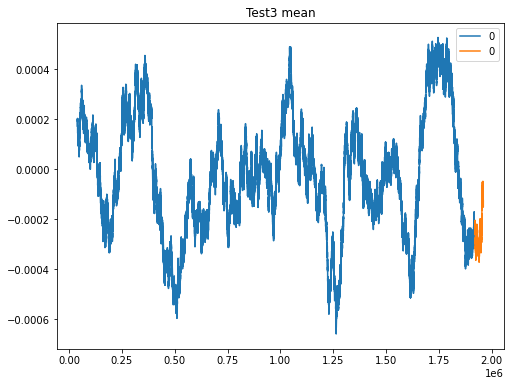

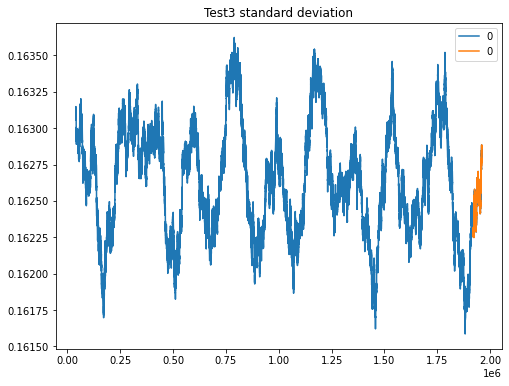

In [0]:
df_T3 = pd.DataFrame(data_T3)
windowW=80000
df_T3_M_roll = df_T3.rolling(window=windowW, win_type=None, center=True).mean()
ax = df_T3_M_roll.iloc[0:df_T3_M_roll.shape[0]-windowW].plot(title='Test3 mean')
df_T3_M_roll.iloc[df_T3_M_roll.shape[0]-windowW:].plot(ax=ax)

df_T3_V_roll = df_T3.rolling(window=windowW, center=True).std()
ax = df_T3_V_roll.plot(title='Test3 standard deviation')
df_T3_V_roll.iloc[df_T3_V_roll.shape[0]-windowW:].plot(ax=ax)

From the rolling window analysis there appears to be some peridocity in the mean and varience in the order of several months of data.

# LSTM predictor Investigation
First attempts with the windowed dataset of the mean and std. The motivation of using an Recurrent Neural Network here are as follows:

*   The ability of such a network to deliver an automated rolling forecast. The generalisation power of neural networks in general, and specifcally the applicability of RNN to time-series analysis means that they are able to update as new data becomes available automatically. For example it is possible to continuously feed in each new day of data and thereby update (re-train) the quality of the forecast with little to no human input. 

* Additionarly, we have opted to use a bidirectional LSTM, which has two context gates, one for the forward flow and one for the backward flow of updates. This is particually well suited to the task of forecasting as each LSTM unit is able to learn based of future and past data. 

After implementation we should have a forecaster which is able to generate reasonable results for not only the 25th month, but allowing for a rolling one month forecast. As already mentioned, it is reativly simple to automatically update the network weights (re-train) as new data becomes available, thereby improving the rolling month prediction continuously.

Here I will work from the assumption that the first 24 'months' can be used as the training data while the 25th month will be used for validation.

## Firstly Build the training data
In order to reduce the RAM and training time requirements we will down sample the time-series taking every 400th datapoint. If we make a comparison between the original and downsampled dataset, the general structure remains intact, see plots below.

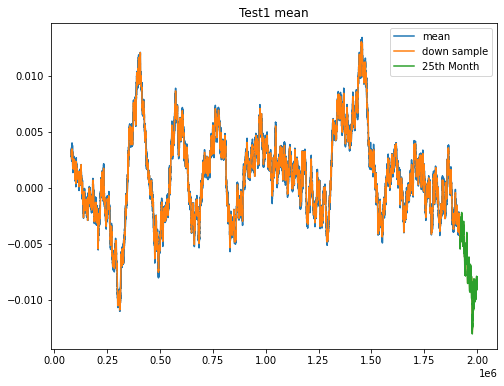

In [0]:
everySampe = 400

df_T1 = pd.DataFrame(data_T1)
windowW=80000

# Rolling window over the dataset
df_T1_M_roll = df_T1.rolling(window=windowW, center=False).mean().dropna()

# Downsample the dataset
df_T1_M_roll_samp = df_T1_M_roll[::everySampe]

# Compare downsampled dataset with dataset
ax = df_T1_M_roll.iloc[0:df_T1_M_roll.shape[0]-windowW].plot(title='Test1 mean')
df_T1_M_roll_samp.plot(ax=ax)
df_T1_M_roll.iloc[df_T1_M_roll.shape[0]-windowW:].plot(ax=ax)

ax.legend(["mean", "down sample", "25th Month"]);

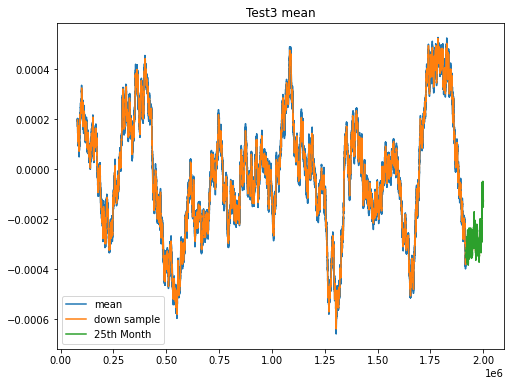

In [0]:
df_T3 = pd.DataFrame(data_T3)
windowW=80000

# Rolling window over the dataset
df_T3_M_roll = df_T3.rolling(window=windowW, center=False).mean().dropna()

# Downsample the dataset
df_T3_M_roll_samp = df_T3_M_roll[::everySampe]

# Compare downsampled dataset with dataset
ax = df_T3_M_roll.iloc[0:df_T3_M_roll.shape[0]-windowW].plot(title='Test3 mean')
df_T3_M_roll_samp.plot(ax=ax)
df_T3_M_roll.iloc[df_T3_M_roll.shape[0]-windowW:].plot(ax=ax)

ax.legend(["mean", "down sample", "25th Month"]);

The comparisons of the downsampled and original data indicate that we see the major observable trends are visible. Lets now build an LSTM network capable of forecasting the mean and varience for each test.
## Segment The Data Into Examples
Each training example is constructed of a window of past measurements (X) and the correspoding labels (Y) which has has a length equal to the desired forecast. In our case we want to forecast 80000 samples into the future which corresponds to one month of data.

We will proceed by training two forecasters per test, one for the mean and one for the standard deviation.

data_train:  (4601, 1)
data_val:  (401, 1)
window width:  200
Target size:  200
The training data dims : (4201, 200, 1)
The training label data dims : (4201, 200) 

The validation data dims : (1, 200, 1)
The validation label data dims : (1, 200)

Single window of past data dims : (200, 1)
Target data to predict dims: (200,)

A single training example


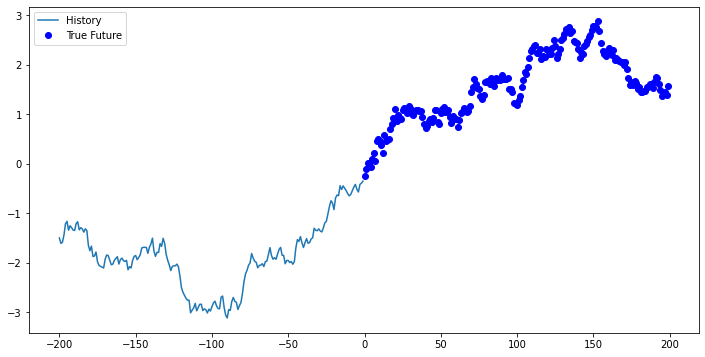

data_train:  (4601, 1)
data_val:  (601, 1)
window width:  400
Target size:  200
The training data dims : (4001, 400, 1)
The training label data dims : (4001, 200) 

The validation data dims : (1, 400, 1)
The validation label data dims : (1, 200)

Single window of past data dims : (400, 1)
Target data to predict dims: (200,)

A single training example


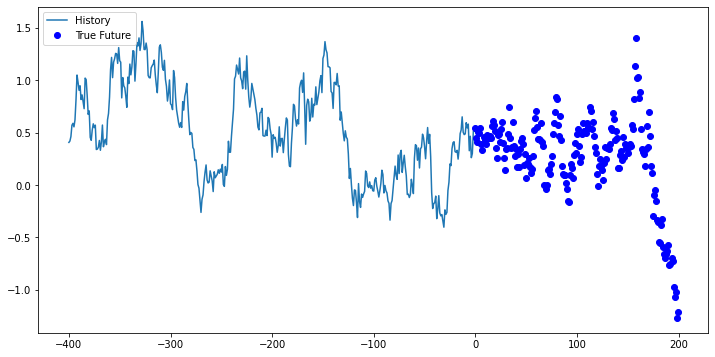

data_train:  (4601, 1)
data_val:  (2601, 1)
window width:  2400
Target size:  200
The training data dims : (2001, 2400, 1)
The training label data dims : (2001, 200) 

The validation data dims : (1, 2400, 1)
The validation label data dims : (1, 200)

Single window of past data dims : (2400, 1)
Target data to predict dims: (200,)

A single training example


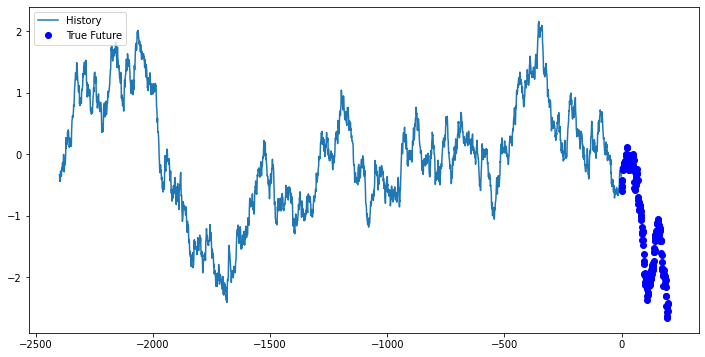

data_train:  (4601, 1)
data_val:  (2601, 1)
window width:  2400
Target size:  200
The training data dims : (2001, 2400, 1)
The training label data dims : (2001, 200) 

The validation data dims : (1, 2400, 1)
The validation label data dims : (1, 200)

Single window of past data dims : (2400, 1)
Target data to predict dims: (200,)

A single training example


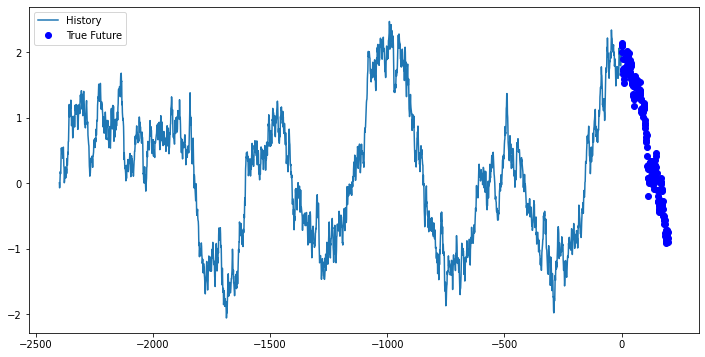

In [0]:
# Re-import all available data into a single vector
data_T1, _ = forecasterNN.dataGet(folder_test1, split=None)
data_T3, _ = forecasterNN.dataGet(folder_test3, split=None)

rolling_window = 80000  # The rolling window of one month
down_sample = 400  # The downsampling of the data
target_size = 80000 # The desired forecast of one month
split = 80000 * 24 # Segment the training data from the test data.
STEP=1




# The test1 dataset
window_width_fractor = 1 # Controls the size of the history window used for each example
train_dataM1, val_dataM1, BATCH_SIZE, target_size, trainScaleM1, valScaleM1 = forecasterNN.dataTrain(data_T1, rolling_window, down_sample, 
                                           target_size, window_width_fractor, 
                                           split, stat='mean', STEP=1, stride=1, 
                                           BATCH_SIZE = 128, BUFFER_SIZE = 1000)

target_size = 80000 
window_width_fractor = 2 
train_dataS1, val_dataS1, BATCH_SIZE, target_size, trainScaleS1, valScaleS1 = forecasterNN.dataTrain(data_T1, rolling_window, down_sample, 
                                           target_size, window_width_fractor, 
                                           split, stat='std', STEP=1, stride=1, 
                                           BATCH_SIZE = 64, BUFFER_SIZE = 1000)

# The test3 dataset
target_size = 80000 
window_width_fractor = 12
train_dataM3, val_dataM3, BATCH_SIZE, target_size, trainScaleM3, valScaleM3 = forecasterNN.dataTrain(data_T3, rolling_window, down_sample, 
                                           target_size, window_width_fractor, 
                                           split, stat='mean', STEP=1, stride=1, 
                                           BATCH_SIZE = 64, BUFFER_SIZE = 1000)

target_size = 80000 
train_dataS3, val_dataS3, BATCH_SIZE, target_size, trainScaleS3, valScaleS3  = forecasterNN.dataTrain(data_T3, rolling_window, down_sample, 
                                           target_size, window_width_fractor, 
                                           split, stat='std', STEP=1, stride=1, 
                                           BATCH_SIZE = 64, BUFFER_SIZE = 1000)

## Define the network
I have run a few trials on a good blanace between the number of LSTM layers, number of units within each layer, and the optimizer. As expected the bidirectional LSTM layers learn much better, and have a lower validation error, meaning they are able to generalise better than a single directional LSTM layer. While there are undoubtly improvements, I have arrived on the following structure:


1.   Layer 1: Bidirectional 64 unit LSTM (default activation is tanh)
2.   Layer 2: Bidirectional 64 unit LSTM (default activation is tanh)
3.   Layer 3: Bidirectional 64 unit LSTM (default activation is tanh)
4.   Layer 4: Dense of size equal to the forecast of one month (200 samples in downsampled dataset)



In [0]:
def modelDefine(window_dims, units=64):
  '''Define the dimensions of the layer
  '''
  # %% Define the model
  tf.keras.backend.clear_session()
  tf.random.set_seed(51)
  model = tf.keras.models.Sequential([
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units,
                                        return_sequences=True,
                                        input_shape=window_dims)),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units,
                                        return_sequences=True)),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units)),
          tf.keras.layers.Dense(target_size)])
  model.compile(loss="mse", optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95))

  return model

## Begin training
### test1 data
Starting with a network to forecast the mean

In [0]:
for x, z in train_dataM1.take(1):
  window=x[0].numpy().shape



Uncomment cell below to retrain the model

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

128/128 [==============================] - 15s 119ms/step - loss: 0.7988 - val_loss: 0.8904
Epoch 2/5
128/128 [==============================] - 14s 108ms/step - loss: 0.6847 - val_loss: 0.7312
Epoch 3/5
128/128 [==============================] - 14s 108ms/step - loss: 0.6054 - val_loss: 0.7153
Epoch 4/5
128/128 [==============================] - 14s 107ms/step - loss: 0.5644 - val_loss: 0.6500
Epoch 5/5
128/128 [==============================] - 14s 108ms/step - loss: 0.5337 - val_loss: 0.703

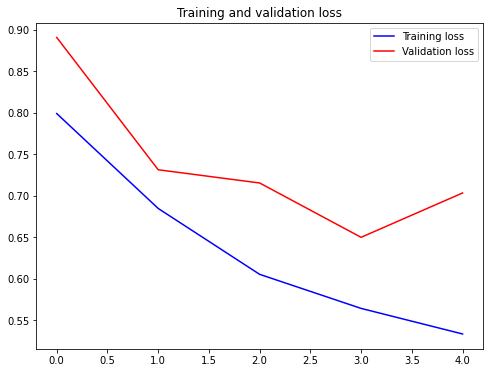

In [0]:
# modelM1 = modelDefine(window, units=128)
# EPOCHS = 5
# # Clip the max number of interations during each epoch, max is BATCH_SIZE
# EVALUATION_INTERVAL = 128 
# history = modelM1.fit(train_dataM1,epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
#                                           validation_data=val_dataM1,
#                                           validation_steps=1)

# modelM1.save('modelM1.h5')
# forecasterNN.plot_train_history(history,
#                    'Training and validation loss')

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

64/64 [==============================] - 8s 119ms/step - loss: 0.8634 - val_loss: 0.5705
Epoch 2/30
64/64 [==============================] - 6s 94ms/step - loss: 0.7109 - val_loss: 0.5568
Epoch 3/30
64/64 [==============================] - 6s 94ms/step - loss: 0.6775 - val_loss: 0.2832
Epoch 4/30
64/64 [==============================] - 6s 93ms/step - loss: 0.6035 - val_loss: 0.4578
Epoch 5/30
64/64 [==============================] - 6s 93ms/step - loss: 0.5883 - val_loss: 0.6107
Epoch 6/30
6

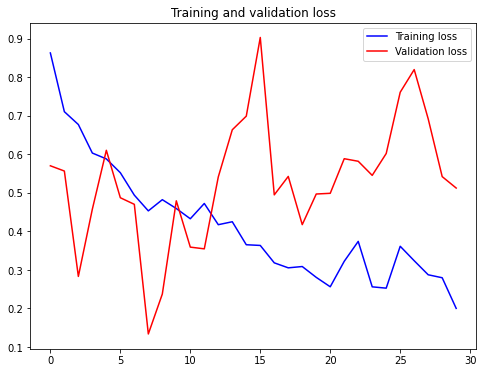

In [0]:
# modelS1 = modelDefine(window)
# EPOCHS = 30
# # Clip the max number of interations during each epoch, max is BATCH_SIZE
# EVALUATION_INTERVAL = BATCH_SIZE 
# history = modelS1.fit(train_dataS1,epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
#                                           validation_data=val_dataS1,
#                                           validation_steps=1)

# modelS1.save('modelS1.h5')
# forecasterNN.plot_train_history(history,
#                    'Training and validation loss')

Test3 dataset

In [0]:
# modelM3 = modelDefine(window)
# EPOCHS = 6
# # Clip the max number of interations during each epoch, max is BATCH_SIZE
# EVALUATION_INTERVAL = BATCH_SIZE 
# history = modelM3.fit(train_dataM3,epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
#                                           validation_data=val_dataM3,
#                                           validation_steps=1)

# modelM3.save('modelM3.h5')
# forecasterNN.plot_train_history(history,
#                    'Training and validation loss')

In [0]:
# EPOCHS = 5
# modelS3 = modelDefine(window)
# # Clip the max number of interations during each epoch, max is BATCH_SIZE
# EVALUATION_INTERVAL = BATCH_SIZE 
# history = modelS3.fit(train_dataS3,epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
#                                           validation_data=val_dataS3,
#                                           validation_steps=1)
# modelS3.save('modelS3.h5')
# forecasterNN.plot_train_history(history,
#                    'Training and validation loss')

Have a look at the training history

## Evaluate Each forecaster
Starting with the test1 dataset, we can now evaluate our trained model by visually inspecting how well it does in predicting the 25th month of data in terms of the mean and standard deviation. Just to be clear the network was trained on data from the first 24 months, while the 25th month was used as the validation set to determine how well the network generalises. Note I have kept everything in standadised units. 

### Forecasting the 25th month of test1

In [0]:
# Load the pre-trained model
modelS1 = tf.keras.models.load_model('myDatasets/modelS1.h5')
modelM1 = tf.keras.models.load_model('myDatasets/modelM1.h5')

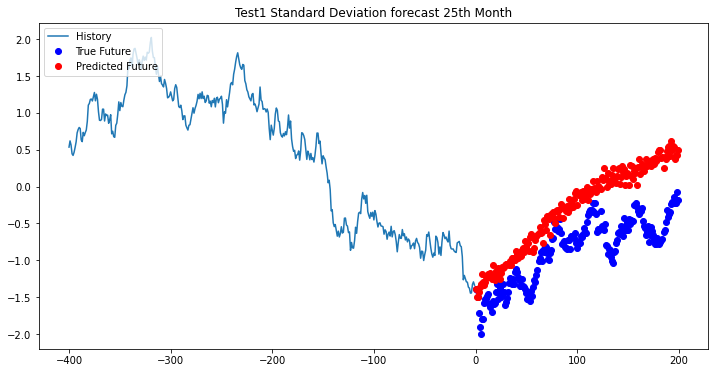

In [0]:
for x, y in val_dataS1.take(1):
  forecasterNN.plot_forecast(x[0], y[0], modelS1.predict(x)[0], step=STEP, title='Test1 Standard Deviation forecast 25th Month')

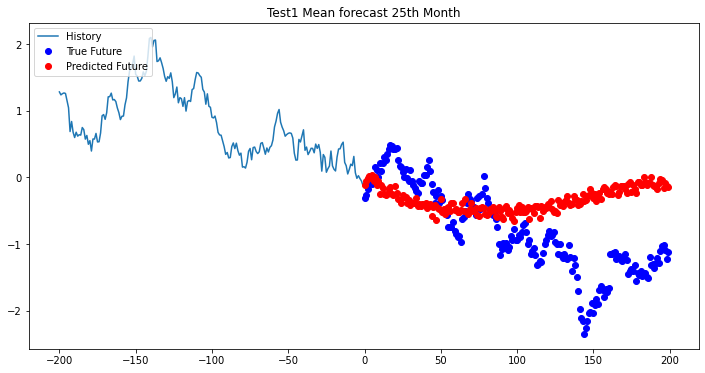

In [0]:
for x, y in val_dataM1.take(1):
  forecasterNN.plot_forecast(x[0], y[0], modelM1.predict(x)[0], step=STEP, title='Test1 Mean forecast 25th Month')

We can generate the original data structure from out forecast of the mean and standard deviation.

In [0]:
Month25th, mean25th, std25th = forecasterNN.dataReform(modelM1, modelS1, val_dataM1, val_dataS1, valScaleM1, 
                        valScaleS1, down_sample, numSamp=80000)

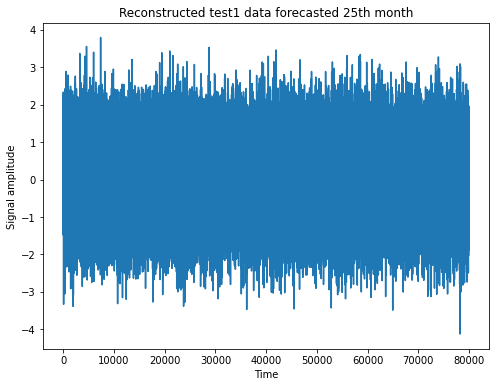

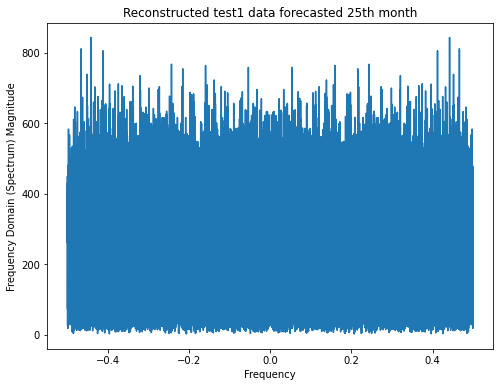

In [0]:
forecasterNN.dataFFT(Month25th, title='Reconstructed test1 data forecasted 25th month')

We can also compare against the out baseline forecaster.

The squared error for test1 mean RNN is 5.37e-07
The squared error for test1 std. RNN is 9.74e-06
The squared error for test1 mean is 1.41e-05
The squared error for test1 std. is 3.62e-06


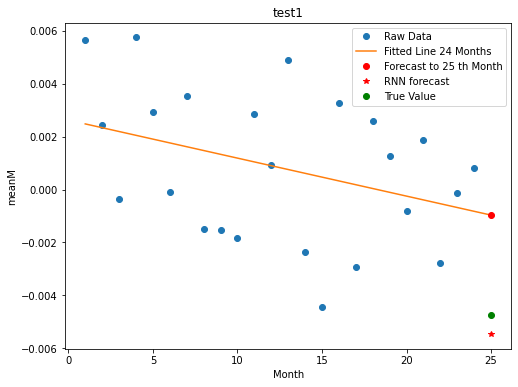

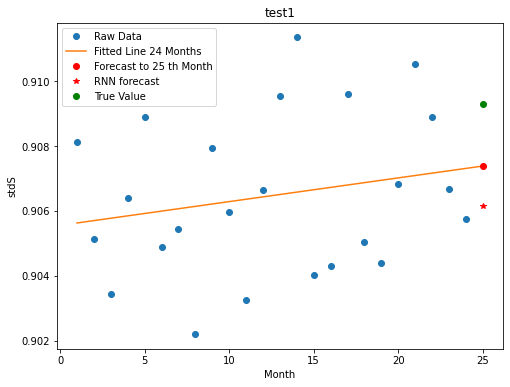

In [0]:
baseErrorTest1M, baseErrorTest1S = forecasterNN.baselinePlot(dataM_T1, 1, 
                                                title = 'test1', 
                                                standadize=False,
                                                NNmean=mean25th, 
                                                NNstd=std25th)

Through the above comparison we note that the RNN does a better job of forecasting the average mean for month 25, though a less good job of forecasting the std. That said if we observe the trend of the mean and std. forecast from our RNN, it is clear that in both cases the RNN is able to capture the structure, while obviously the baseline forecasting is just a single datapoint.

### Forecasting the 25th month of test3

In [0]:
# Load the pre-trained model
modelS3 = tf.keras.models.load_model('myDatasets/modelS3.h5')
modelM3 = tf.keras.models.load_model('myDatasets/modelM3.h5')

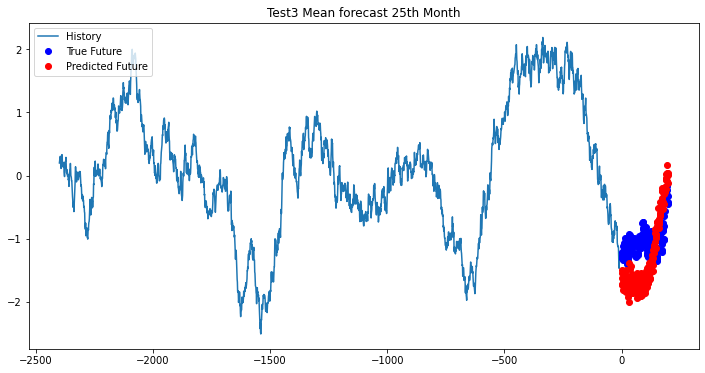

In [0]:
for x, y in val_dataM3.take(1):
  forecasterNN.plot_forecast(x[0], y[0], modelM3.predict(x)[0], step=STEP, title='Test3 Mean forecast 25th Month')

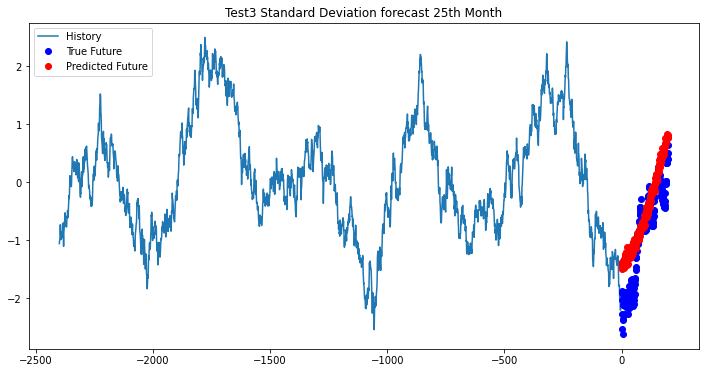

In [0]:
for x, y in val_dataS3.take(1):
  forecasterNN.plot_forecast(x[0], y[0], modelS3.predict(x)[0], step=STEP, title='Test3 Standard Deviation forecast 25th Month')

We can generate the original data structure from out forecast of the mean and standard deviation.

In [0]:
Month25th, mean25th, std25th = forecasterNN.dataReform(modelM3, modelS3, val_dataM3, val_dataS3, valScaleM3, 
                        valScaleS3, down_sample, numSamp=80000)

The squared error for test3 mean RNN is 2.22e-07
The squared error for test3 std. RNN is 1.58e-08
The squared error for test3 mean is 5.2e-07
The squared error for test3 std. is 1.17e-07


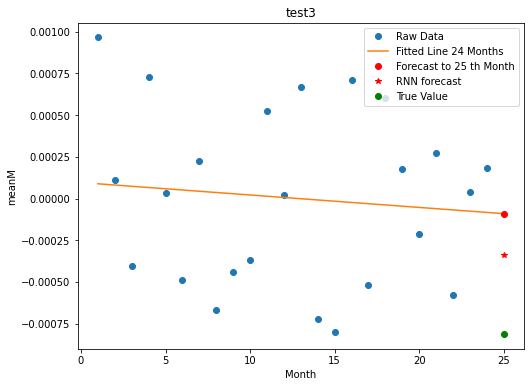

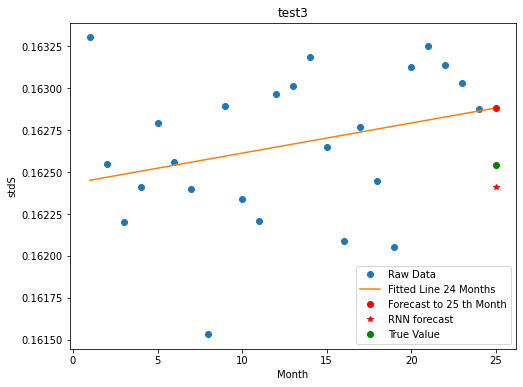

In [0]:
baseErrorTest3M, baseErrorTest3S = forecasterNN.baselinePlot(dataM_T3, 1, 
                                                title = 'test3', 
                                                standadize=False,
                                                NNmean=mean25th, 
                                                NNstd=std25th)

Through the above comparison, we note that out RNN does a better job of forecasting both the average std and mean for month 25. Also the trend of the mean and std. forecast from our RNN is evident, while obviously, the baseline forecasting is just a single datapoint.

# Concluding Remarks
In this notebook, we firstly inspected the data structure and observe a signature which looked mostly "white", though some transient month to month trends were visible in the mean and std of the data. This motivated an initial baseline forecaster which simply extrapolated the observed trends. In an attempt to improve on this, we constructed a Recurrent Neural Network (RNN) from bidirectional LSTM units. These networks were then trained on data from the first 24 months (columns) with the goal of forecasting the 25th month.


From these initial attempts, we have demonstrated the general efficacy of RNN, and specifically LSTM bidirectional networks to the problem of time series forecasting. That said, there are many possible paths to improving the structure of these RNN models in relation to the above forecasting task. These can be summarised as follows:

1.  Tune the parameters: In the above analysis, we have constructed parameters such as the batch size, number of epochs, number of LSTM units, length of the history window, ..etc based on a reasonable training time and a trial and error approach concerning how well the model generalises. All of the above can be automated and turned to improve the forecast. 
2.  Train on two input featured: A logical next step would be to input both the mean and std. as features into the network with the labels kept as the raw time series. This would avoid a lot of post-processing, though due to the large number of required forecasts, RAM constraints will arise (at least on a personal computer). 
3.  Change the preprocessing steps: I would also advocate changing the feature engineering of the training data. A popular method used in time-series analysis in both the geophysics and ML communities is to perform a wavelet transform of the series prior to training. This is a good way of constraining amplitude, and frequency information in time. Such pre-processing is often used in activation word detection ('hey siri', "ok google", "Alexa"...etc).
4.  Get more training data: As is always the case, more training data will help the network to generalise better (i.e. forecast well on the 25th, 26th, 27th month of data).

Another important remark to make is that the trained LSTM network can be updated easily as more data becomes available, often without the need to retrain on the entire dataset. This makes such a forecasting approach particularly powerful when one expects continuous drift in the data space. 